# Computing Meridional Overturning

Meriodional Overturning Circulation is a key diagnostic for ocean circulation. This notebook demonstrate how to compute various flavors of it using the [xoverturning](https://github.com/raphaeldussin/xoverturning) package.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr # requires >= 0.15.1
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from xoverturning import calcmoc

Load the sample dataset and geolon/geolat from static file (without holes on eliminated processors). Note that this is working for both symetric and non-symetric grids but the dataset and grid file must be consistent.

```python
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, engine='pydap')
```

In [4]:
root = '/work/noaa/gfdlscr/jkrastin/wmt-inert-tracer/OM4p5_sample/'
ds = xr.open_dataset(root+'ocean_monthly_z.200301-200712.nc4', chunks={'time':1, 'z_l': 1}, 
                     drop_variables=['average_DT','average_T1','average_T2'])

In [5]:
#dsgrid = xr.open_dataset('./data/ocean_grid_nonsym_OM4_05.nc')
dsgrid = xr.open_dataset('../MOM6-AnalysisCookbook/ocean_grid_nonsym_OM4_05.nc')

## A first overturning computation

This computes the meridional overturning circulation (moc) on the whole ocean:

In [6]:
moc = calcmoc(ds, dsgrid=dsgrid)

generating basin codes


The result is given at the vertical interfaces since the streamfunction is the result of the integration of transports over layers and on the q-point because V-velocities are located on (xh, yq) and integrated over the x-axis.

In [7]:
print(moc.dims)

('time', 'z_i', 'yq')


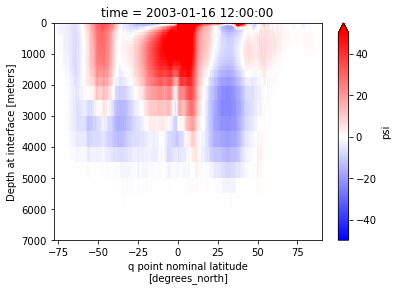

In [8]:
# Plot streamfunction for any given time
moc.sel(time='2003-01').plot(vmin=-50,vmax=50, yincrease=False, cmap='bwr')

In [9]:
with ProgressBar():
    moc_mean = moc.mean('time').load()

[########################################] | 100% Completed |  3min 16.3s


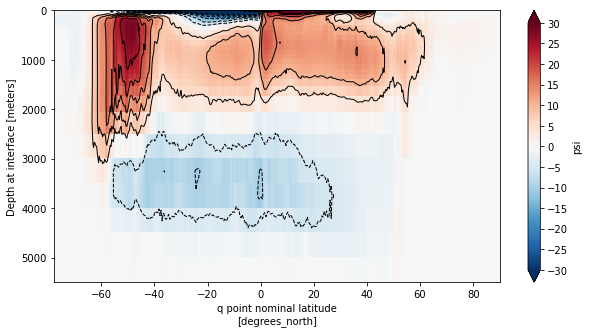

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
moc_mean.plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',cbar_kwargs={'ticks': np.arange(-30,35,5)})
moc_mean.plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                      colors='k', linewidths=1)
ax.set_ylim([5500,0])
plt.show()

## MOC and Basins

xoverturning can compute the MOC over a specified basin. Default is `basin='global'`, but pre-defined available options are `basin='atl-arc'` and `basin='indopac'`. If the grid file contain a basin DataArray produced by [cmip_basins](https://github.com/jkrasting/cmip_basins), it will use it in combination with predefined basin codes to create the basin mask. If the array does not exist, xoverturning will generate it on-the-fly using cmip_basin code. It is also possible to use an arbitrary list of basin codes as argument to `basin`, which could be particularly handy if you have custom build basin codes.

In [11]:
# atlantic
amoc = calcmoc(ds, dsgrid=dsgrid, basin='atl-arc')

generating basin codes


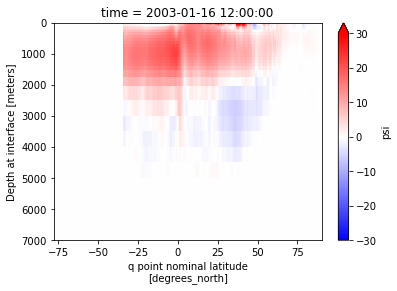

In [12]:
amoc.sel(time='2003-01').plot(vmin=-30,vmax=30, yincrease=False, cmap='bwr')

In [13]:
# indopacific
pmoc = calcmoc(ds, dsgrid=dsgrid, basin='indopac')

generating basin codes


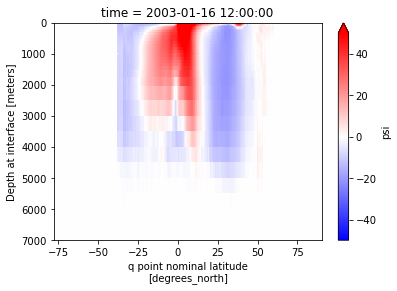

In [14]:
pmoc.sel(time='2003-01').plot(vmin=-50,vmax=50, yincrease=False, cmap='bwr')

## Masking (only in geopotential coordinates)

You can also mask out the ocean floor to make it more plot-friendly with `mask_output`.

In [15]:
amoc = calcmoc(ds, dsgrid=dsgrid, basin='atl-arc', mask_output=True)

generating basin codes


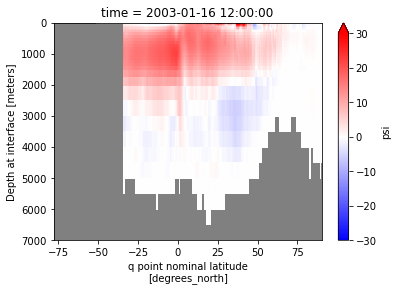

In [16]:
amoc.sel(time='2003-01').plot(vmin=-30,vmax=30, yincrease=False, cmap='bwr', 
                              subplot_kws={'facecolor': 'grey'})

In [17]:
with ProgressBar():
    amoc_mean = amoc.mean('time').load()

[########################################] | 100% Completed |  2min 19.8s


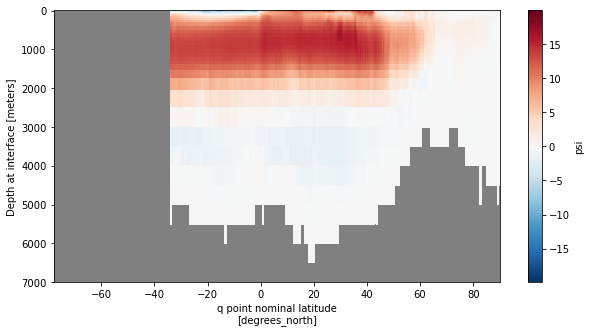

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
amoc_mean.plot(ax=ax, yincrease=False,cmap='RdBu_r',cbar_kwargs={'ticks': np.arange(-30,35,5)})
ax.set_facecolor('grey')
plt.show()

## Derived quantities

Since the output of xoverturning is a xarray.DataArray, computing derived quantities is a breeze thanks to xarray built-in functions:

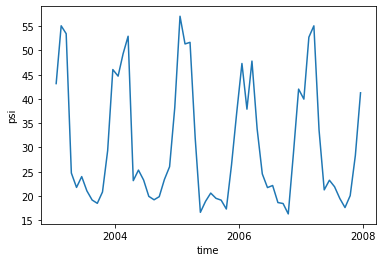

In [19]:
amoc.max(dim=['yq', 'z_i']).plot()

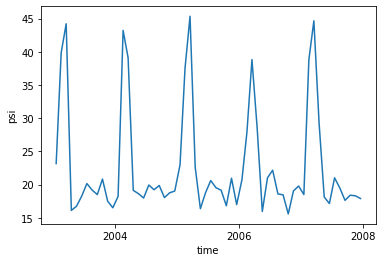

In [20]:
amoc.sel(yq=slice(20.0, 80.0), z_i=slice(100.0, 2500.0)).max(dim=['yq', 'z_i']).plot()

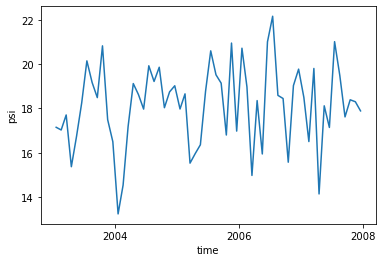

In [21]:
amoc.sel(yq=slice(20.0, 80.0), z_i=slice(500.0, 2500.0)).max(dim=['yq', 'z_i']).plot()

In [22]:
# Find the location of the maximum
yq_max = amoc_mean.argmax(dim=['yq', 'z_i'])['yq']
z_i_max = amoc_mean.argmax(dim=['yq', 'z_i'])['z_i']
print('Maximum:',
      np.round(amoc_mean[z_i_max,yq_max].values,1),'Sv at',
      np.round(amoc_mean.yq[yq_max].values,1),'N and',
      np.round(amoc_mean.z_i[z_i_max].values,1),'m depth')

Maximum: 19.9 Sv at 20.9 N and 15.0 m depth


In [23]:
subset = amoc_mean.sel(yq=slice(20.0, 80.0), z_i=slice(100.0, 2500.0))
yq_max = subset.argmax(dim=['yq', 'z_i'])['yq']
z_i_max = subset.argmax(dim=['yq', 'z_i'])['z_i']

In [24]:
print('Maximum:',
      np.round(subset[z_i_max,yq_max].values,1),'Sv at',
      np.round(subset.yq[yq_max].values,1),'N and',
      np.round(subset.z_i[z_i_max].values,1),'m depth')

Maximum: 17.0 Sv at 30.0 N and 650.0 m depth


## Density coordinates

Because xoverturning is written in a non-specific vertical coordinate system, it can also compute the MOC in other coordinates system, such as the `rho2` output by using the `vertical='rho2'` option.

```python
pproot = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20201120/'
run = 'CM4_piControl_c96_OM4p25_half_kdadd'
ppdir = f'{pproot}/{run}/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_rho2'

ds_rho2 = xr.open_mfdataset([f"{ppdir}/ts/annual/10yr/ocean_annual_rho2.0021-0030.umo.nc",
                             f"{ppdir}/ts/annual/10yr/ocean_annual_rho2.0021-0030.vmo.nc"])

dsgrid_rho2 = xr.open_dataset(f"{ppdir}/ocean_annual_rho2.static.nc")
```

In [25]:
ppdir = '/work/noaa/gfdlscr/jkrastin/wmt-inert-tracer/OTSFN_sample/'
ds_rho2 = xr.open_mfdataset(ppdir+'ocean_annual_rho2.0021-0030.*.nc',
                            drop_variables=['average_DT','average_T1','average_T2'])

In [26]:
dsgrid_p25 = xr.open_dataset(ppdir[:-13]+'data/raw/CM4_piControl_C/ocean_monthly/ocean_monthly.static.nc')

In [27]:
ds_rho2 = ds_rho2.isel(yq=slice(1,None),xq=slice(1,None))

### Global overturning in density coordinates

In [28]:
moc_rho2 = calcmoc(ds_rho2, dsgrid=dsgrid_p25, vertical='rho2')

generating basin codes


In [29]:
with ProgressBar():
    moc_rho2_mean = moc_rho2.mean('time').load()

[########################################] | 100% Completed | 10.2s


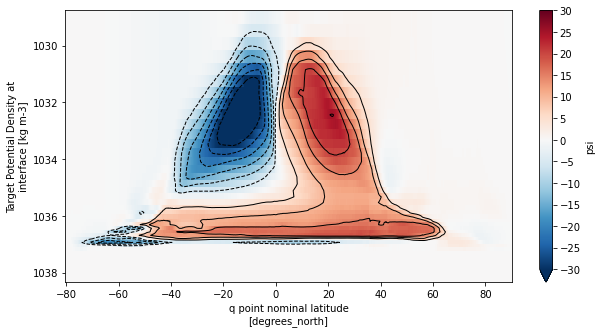

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
moc_rho2_mean.sel(rho2_i=slice(1028.5,None)).plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                                                  cbar_kwargs={'ticks': np.arange(-30,35,5)})
moc_rho2_mean.sel(rho2_i=slice(1028.5,None))\
    .plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                  colors='k', linewidths=1)
plt.show()

### AMOC in density coordinates

In [31]:
amoc_rho2 = calcmoc(ds_rho2,dsgrid=dsgrid_p25, vertical='rho2', basin='atl-arc')

generating basin codes


In [32]:
with ProgressBar():
    amoc_rho2_mean = amoc_rho2.mean('time').load()

[########################################] | 100% Completed | 10.2s


In [33]:
# Find the location of the maximum
yq_max = amoc_rho2_mean.argmax(dim=['rho2_i', 'yq'])['yq']
rho2_i_max = amoc_rho2_mean.argmax(dim=['rho2_i', 'yq'])['rho2_i']
print('Maximum:',
      np.round(amoc_rho2_mean.isel(rho2_i=rho2_i_max,yq=yq_max).values,1),'Sv at',
      np.round(amoc_rho2_mean.yq[yq_max].values,1),'N and',
      np.round(amoc_rho2_mean.rho2_i[rho2_i_max].values,1),'kg/m^3 density')

Maximum: 20.0 Sv at 16.2 N and 1036.7 kg/m^3 density


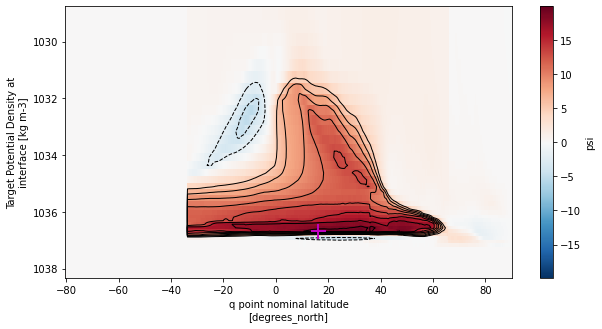

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
amoc_rho2_mean.sel(rho2_i=slice(1028.5,None)).plot(ax=ax, yincrease=False,cmap='RdBu_r',
                                                  cbar_kwargs={'ticks': np.arange(-30,35,5)})
amoc_rho2_mean.sel(rho2_i=slice(1028.5,None))\
    .plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-20,0,2),np.arange(5,22,2)]), 
                  colors='k', linewidths=1)
# Plot location of maximum
ax.plot(amoc_rho2_mean.yq[yq_max],amoc_rho2_mean.rho2_i[rho2_i_max],marker='+',c='m',ms=15,mew=2)
plt.show()

#### Temporal variability in AMOC

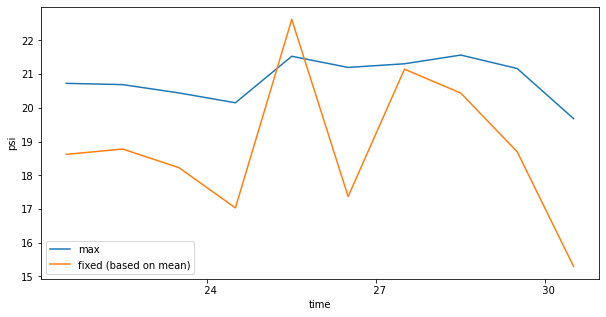

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
amoc_rho2.max(dim=['rho2_i', 'yq']).plot(ax=ax,label='max')
moc_rho2.isel(rho2_i=rho2_i_max,yq=yq_max).plot(ax=ax,label='fixed (based on mean)',_labels=None)
ax.legend(loc='lower left')

In [36]:
df = pd.DataFrame({'MOC_max': amoc_rho2.max(dim=['rho2_i', 'yq']).values, 
                   'rho2_max': amoc_rho2.rho2_i[amoc_rho2.argmax(dim=['rho2_i', 'yq'])['rho2_i'].values],
                   'yq_max': amoc_rho2.yq[amoc_rho2.argmax(dim=['rho2_i', 'yq'])['yq'].values]}, 
                  columns=['MOC_max', 'rho2_max','yq_max'])
print(df)

     MOC_max   rho2_max     yq_max
0  20.726299  1036.6875  32.691579
1  20.688719  1036.6875  28.166723
2  20.441734  1036.6875  46.311188
3  20.150070  1036.5625  36.195427
4  21.529745  1036.6875  13.255155
5  21.198574  1036.5625  36.998263
6  21.306437  1036.6875  16.636192
7  21.564934  1036.6875  48.840297
8  21.165529  1036.6875  18.779436
9  19.679716  1036.6875  -9.086668


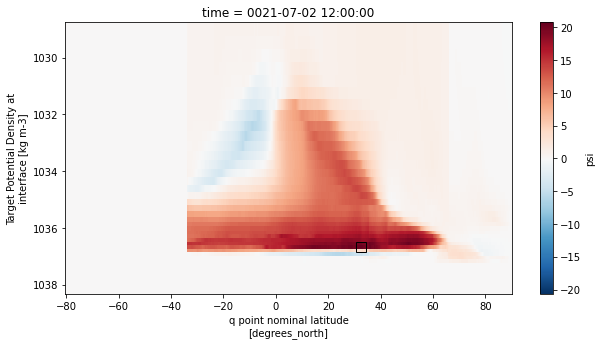

In [37]:
fig, ax = plt.subplots(figsize=(10,5))

amoc_rho2[0].sel(rho2_i=slice(1028.5,None)).plot(ax=ax, yincrease=False,cmap='RdBu_r')
ax.plot(df.iloc[0,2],df.iloc[0,1],marker='s',c='k',ms=10,mew=1,mfc='none')
plt.show()

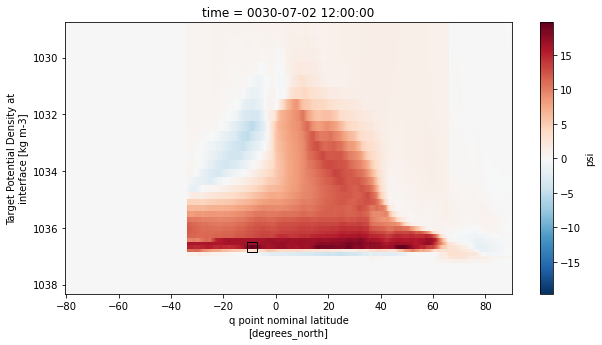

In [38]:
fig, ax = plt.subplots(figsize=(10,5))

amoc_rho2[9].sel(rho2_i=slice(1028.5,None)).plot(ax=ax, yincrease=False,cmap='RdBu_r')
ax.plot(df.iloc[9,2],df.iloc[9,1],marker='s',c='k',ms=10,mew=1,mfc='none')
plt.show()

### Southern Ocean MOC in density coordinates

In [39]:
rho0 = 1035.0

In [40]:
# Calculate streamfunction
vmo_so = ds_rho2.vmo.where(ds_rho2.vmo<1e14).sel(rho2_l=slice(1033,1038),yq=slice(-80,0))
psi_so = (vmo_so.sum('xh').cumsum('rho2_l') - vmo_so.sum('xh').sum('rho2_l'))/rho0/1.0e6 + 0.1

> Note conversion from kg s$^{-1}$ to Sv (10$^6$ m$^3$ s$^{-1}$):
$$\frac{\psi}{\rho_0 10^6}$$

In [41]:
with ProgressBar():
    smoc_rho2_mean = psi_so.mean('time').load()

[########################################] | 100% Completed |  9.4s


In [42]:
# Find the location of the minimum (lower limb overturning)
smoc_lower_mean = smoc_rho2_mean.sel(rho2_l=slice(1028.5,None),yq=slice(None,-30))
yq_min_idx = smoc_lower_mean.argmin(dim=['rho2_l', 'yq'])['yq']
rho2_min_idx = smoc_lower_mean.argmin(dim=['rho2_l', 'yq'])['rho2_l']
print('Minimum:',
      np.round(smoc_lower_mean.isel(rho2_l=rho2_min_idx,yq=yq_min_idx).values,1),'Sv at',
      np.round(smoc_lower_mean.yq[yq_min_idx].values,1),'N and',
      np.round(smoc_lower_mean.rho2_l[rho2_min_idx].values,1),'kg/m^3 density')

Minimum: -19.1 Sv at -63.5 N and 1037.0 kg/m^3 density


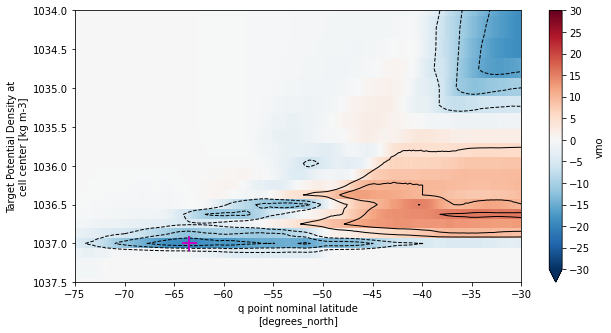

In [43]:
fig, ax = plt.subplots(figsize=(10,5))

smoc_rho2_mean.plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                    cbar_kwargs={'ticks': np.arange(-30,35,5)})
smoc_rho2_mean.plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                            colors='k', linewidths=1)
# Plot location of minimum
ax.plot(smoc_lower_mean.yq[yq_min_idx],smoc_lower_mean.rho2_l[rho2_min_idx],marker='+',c='m',ms=15,mew=2)
ax.set_xlim((-75,-30))
ax.set_ylim((1037.5,1034))
plt.show()

Compare streamfunction to the version obtained from xoverturning

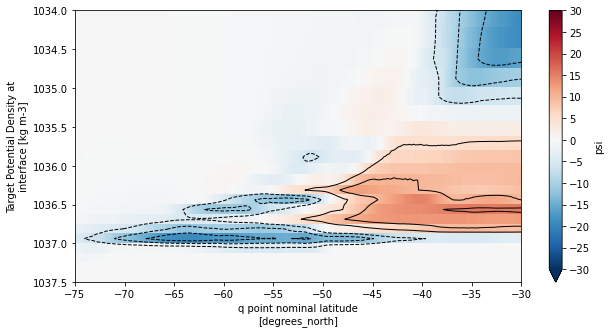

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
moc_rho2_mean.sel(rho2_i=slice(1033,1038),yq=slice(-80,0)).plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                    cbar_kwargs={'ticks': np.arange(-30,35,5)})
moc_rho2_mean.sel(rho2_i=slice(1033,1038),yq=slice(-80,0))\
    .plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                  colors='k', linewidths=1)

ax.set_xlim((-75,-30))
ax.set_ylim((1037.5,1034))
plt.show()

## Remap meridional transport to density coordinates

Ideally, computation should use `vmo` from `rho2` output, but it is possible to use output in z coordinates and compute the isopycnal overturning offline by first vertically remapping the meridional transport from depth to density levels.

Here, we can use [xgcm](https://xgcm.readthedocs.io/en/latest/index.html) (in particular the [transform](https://xgcm.readthedocs.io/en/latest/transform.html) method) to compute the isopycnal overturning offline and then compare it to the online `rho2` coordinate overturning.

We will focus here on the Southern Ocean MOC. Let's start by loading the relevant data on the z grid and defining and xgcm grid object.

### Load data and build an xgcm grid object

In [45]:
ds_z = xr.open_mfdataset(ppdir+'ocean_annual_z.0021-0030.*.nc',
                         drop_variables=['average_DT','average_T1','average_T2'])

In [46]:
# Subset dataset to the non-symmetric grid dataset
ds_z = ds_z.isel(yq=slice(1,None),xq=slice(1,None))

In [47]:
from xgcm import Grid

In [48]:
# Create a pseudo-grid in the vertical
ds_z['dzt'] = xr.DataArray(data=ds_z['z_i'].diff('z_i').values, coords={'z_l': ds_z['z_l']}, dims=('z_l'))

In [49]:
# Make sure to fill in NaNs with zeros
ds_z['dxt'] = dsgrid_p25['dxt'].fillna(0.)
ds_z['dyt'] = dsgrid_p25['dyt'].fillna(0.)
ds_z['areacello'] = dsgrid_p25['areacello'].fillna(0.)
ds_z['volcello'] = ds_z['volcello'].fillna(0.)

In [50]:
metrics = {
    ('X',): ['dxt'], # X distances
    ('Y',): ['dyt'], # Y distances
    ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    ('X', 'Y', 'Z'): ['volcello'], # Volumes
}

coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'z_l', 'outer': 'z_i'}}

In [51]:
xgrid = Grid(ds_z, coords=coords, metrics=metrics, periodic=['X'])

### Density field
We also need a density field to which we remap the meridional transport variable `vmo`. There are several python packages for computations using the Equation Of State (e.g., [gsw](https://teos-10.github.io/GSW-Python/) or [xgcm/fastjmd95](https://github.com/xgcm/fastjmd95)). To stay consistent with MOM6, one would use the Wright 97 EOS  model. The example below will use fastjmd95 to calculate potential density referenced at 2000 dbar.

In [52]:
import fastjmd95 as jmd95

In [53]:
ds_z['rho2'] = jmd95.rho(ds_z.so, ds_z.thetao, 2000)

In [54]:
from xhistogram.xarray import histogram

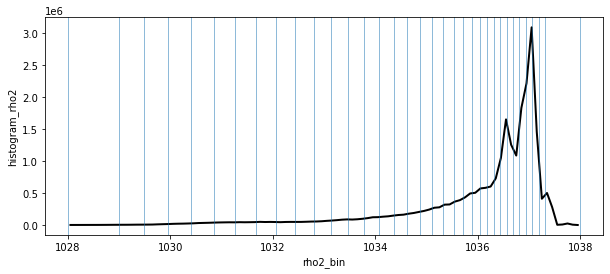

In [55]:
fig, ax = plt.subplots(1,1, figsize=[10,4])
histogram(ds_z.rho2.isel(time=0), bins = [np.linspace(1028, 1038, 101)], density=True).plot(ax=ax,lw=2,c='k')
for val in ds_rho2.rho2_i.values[1:]:
    ax.axvline(x=val,lw=1,alpha=0.5)

Given the fairly skewed distribution of density towards high values it makes sense to define a density axis with more refined spacing in the high density ranges.

In [56]:
# Define density axis
rho2_axis = ds_rho2.rho2_i.values

### Remap `vmo` with `xgcm.transform`

In [57]:
vmo = ds_z.vmo.where(dsgrid_p25['wet_v']==1)

In [58]:
# Interpolate density values to vmo grid
rho2 = xgrid.interp(ds_z.rho2, 'Y', boundary='extend').rename('rho2').chunk({'z_l':-1})

In [59]:
# Transform into sigma1 coords
vmo_rho2 = xgrid.transform(vmo.chunk({'z_l':-1}), target = rho2_axis, target_data=rho2, 
                           method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

In [60]:
# Check if density coodinated of remapped data is the same as in the original rho2 dataset
pd.DataFrame({'original': ds_rho2.rho2_l.values, 'transform': vmo_rho2.rho2.values}, 
             columns=['original', 'transform'])

,original,transform
0,1013.750000,1013.750000
1,1028.500000,1028.500000
2,1029.242188,1029.242188
3,1029.718750,1029.718750
4,1030.179688,1030.179688
5,1030.625000,1030.625000
6,1031.054688,1031.054688
7,1031.468750,1031.468750
8,1031.867188,1031.867188
9,1032.250000,1032.250000


In [61]:
# Calculate streamfunction
vmo_so_offline = vmo_rho2.where(vmo_rho2<1e14).sel(rho2=slice(1033,1038),yq=slice(-80,0))
psi_so_offline = (vmo_so_offline.sum('xh').cumsum('rho2') - vmo_so_offline.sum('xh').sum('rho2'))/rho0/1.0e6 + 0.1

In [62]:
with ProgressBar():
    smoc_rho2_offline_mean = psi_so_offline.mean('time').load()

[########################################] | 100% Completed | 51.2s


In [63]:
# Find the location of the minimum (lower limb overturning)
smoc_lower_offline_mean = smoc_rho2_offline_mean.sel(rho2=slice(1028.5,None),yq=slice(None,-50))
yq_min_offline_idx = smoc_lower_offline_mean.argmin(dim=['rho2', 'yq'])['yq']
rho2_min_offline_idx = smoc_lower_offline_mean.argmin(dim=['rho2', 'yq'])['rho2']
print('Minimum:',
      np.round(smoc_lower_offline_mean.isel(rho2=rho2_min_offline_idx,yq=yq_min_offline_idx).values,1),'Sv at',
      np.round(smoc_lower_offline_mean.yq[yq_min_offline_idx].values,1),'N and',
      np.round(smoc_lower_offline_mean.rho2[rho2_min_offline_idx].values,1),'kg/m^3 density')

Minimum: -15.1 Sv at -64.9 N and 1037.0 kg/m^3 density


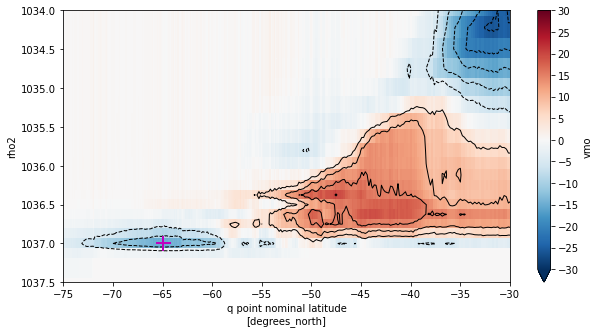

In [64]:
fig, ax = plt.subplots(figsize=(10,5))

smoc_rho2_offline_mean.T.plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                              cbar_kwargs={'ticks': np.arange(-30,35,5)})
smoc_rho2_offline_mean.T\
    .plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                  colors='k', linewidths=1)
# Plot location of minimum
ax.plot(smoc_lower_offline_mean.yq[yq_min_offline_idx],smoc_lower_offline_mean.rho2[rho2_min_offline_idx],
        marker='+',c='m',ms=15,mew=2)
ax.set_xlim((-75,-30))
ax.set_ylim((1037.5,1034))
plt.show()

In [65]:
# Difference between offline and online
delta = smoc_rho2_offline_mean.T.rename({'rho2':'rho2_l'}) - smoc_rho2_mean

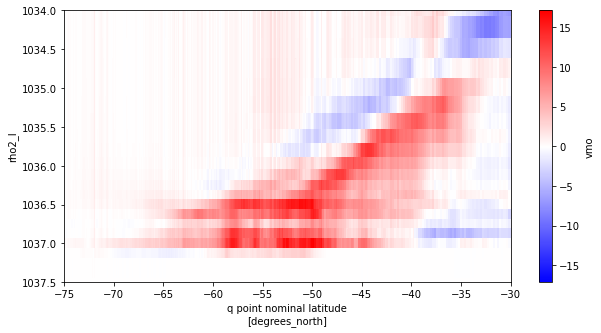

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
delta.plot(ax=ax, yincrease=False,cmap='bwr')
ax.set_xlim((-75,-30))
ax.set_ylim((1037.5,1034))
plt.show()

In [67]:
smoc_lower_online = psi_so.sel(rho2_l=slice(1028.5,None),yq=slice(None,-50))
smoc_lower_offline = psi_so_offline.sel(rho2=slice(1028.5,None),yq=slice(None,-50))

In [68]:
df = pd.DataFrame({
    'Min (online)': smoc_lower_online.min(dim=['rho2_l', 'yq']).values,
    'Min (offline)': smoc_lower_offline.min(dim=['rho2', 'yq']).values,
    'rho2_min_online': smoc_lower_online.rho2_l[smoc_lower_online.argmin(dim=['rho2_l', 'yq'])['rho2_l'].values],
    'rho2_min_offline': smoc_lower_offline.rho2[smoc_lower_offline.argmin(dim=['rho2', 'yq'])['rho2'].values], 
    'yq_min_online': smoc_lower_online.yq[smoc_lower_online.argmin(dim=['rho2_l', 'yq'])['yq'].values],
    'yq_min_offline': smoc_lower_offline.yq[smoc_lower_offline.argmin(dim=['rho2', 'yq'])['yq'].values]}, 
    columns=['Min (online)', 'Min (offline)','rho2_min_online','rho2_min_offline','yq_min_online','yq_min_offline'])
print(df)

   Min (online)  Min (offline)  rho2_min_online  rho2_min_offline  \
0    -28.495102     -19.482939         1037.000            1037.0   
1    -23.202520     -15.596636         1037.000            1037.0   
2    -21.443588     -16.027849         1037.000            1037.0   
3    -21.286764     -15.204092         1036.875            1037.0   
4    -20.924694     -16.823597         1036.875            1037.0   
5    -15.922176     -12.753931         1037.000            1037.0   
6    -18.509733     -15.922901         1037.000            1037.0   
7    -22.771084     -16.349289         1036.625            1037.0   
8    -20.515707     -14.393363         1036.625            1037.0   
9    -20.653469     -15.485858         1037.000            1037.0   

   yq_min_online  yq_min_offline  
0     -59.834021      -61.307763  
1     -62.715357      -63.728938  
2     -62.715357      -65.857156  
3     -55.138698      -65.857156  
4     -54.995544      -65.340774  
5     -51.404080      -65.5485

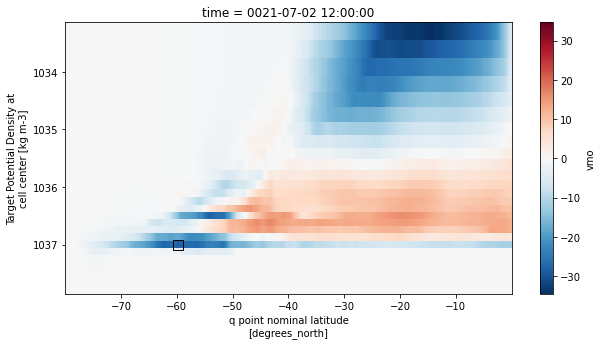

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
psi_so.sel(rho2_l=slice(1028.5,None))[0].plot(ax=ax, yincrease=False,cmap='RdBu_r')
ax.plot(df.iloc[0,4],df.iloc[0,2],marker='s',c='k',ms=10,mew=1,mfc='none')
plt.show()

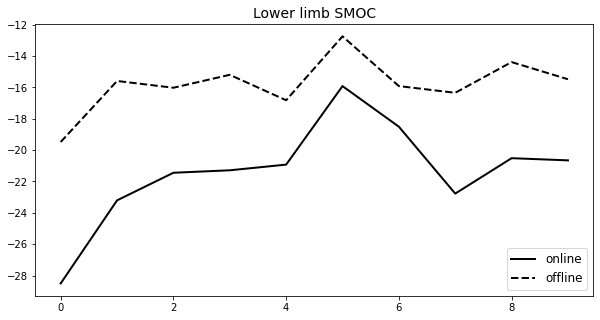

In [70]:
fig, ax = plt.subplots(figsize=(10,5))
df['Min (online)'].plot(ax=ax,label='online',lw=2,c='k')
df['Min (offline)'].plot(ax=ax,label='offline',lw=2,c='k',ls='--')
ax.legend(loc='lower right',fontsize=12)
ax.set_title('Lower limb SMOC',fontsize=14)
plt.show()

### Reproject `rho2` overturning to z coordinates

In [71]:
thk_p25 = ds_rho2.mean('time').thkcello.values
#thk_p25 = np.ma.masked_greater(thk_p25,1e10)
print(thk_p25.shape,np.ma.is_masked(thk_p25))

(35, 1080, 1440) False


In [72]:
# Thickness mapped to rho2 
thk = ds_rho2.thkcello.where(ds_rho2.thkcello<1e10).mean('time')

# Cumulative sum of thickness to get the time averaged depth of an isopycnal 
zrho = thk.mean('xh').cumsum('rho2_l')

In [73]:
# Calculate streamfunction
vmo = ds_rho2.vmo.where(ds_rho2.vmo<1e14).mean('time')
psi = (vmo.sum('xh').cumsum('rho2_l') - vmo.sum('xh').sum('rho2_l'))/rho0/1.0e6 + 0.1

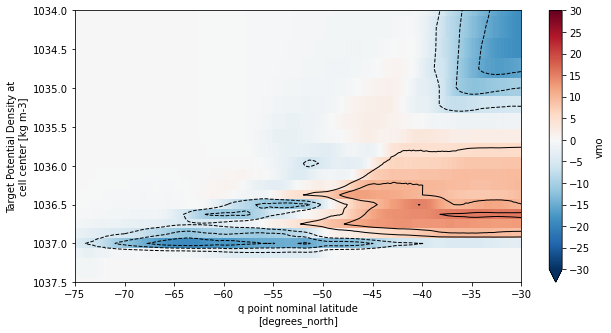

In [74]:
fig, ax = plt.subplots(figsize=(10,5))
psi.plot(ax=ax,x='yq', y='rho2_l',yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                              cbar_kwargs={'ticks': np.arange(-30,35,5)})
psi.plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                 colors='k', linewidths=1)
# Plot location of minimum
ax.set_xlim((-75,-30))
ax.set_ylim((1037.5,1034))
ax.set_facecolor('gray')
plt.show()

In [75]:
psi.coords['depth'] = xgrid.interp(zrho, 'Y', boundary='extend')

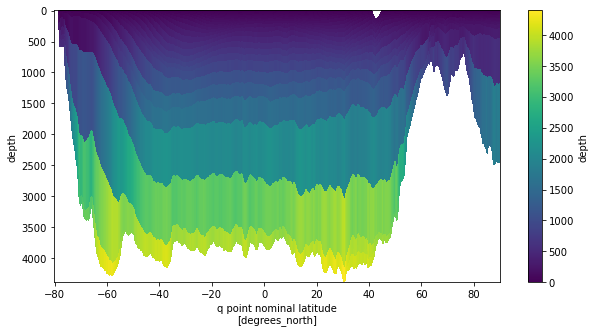

In [76]:
psi.coords['depth'].plot(x='yq', y='depth',yincrease=False,figsize=(10,5))

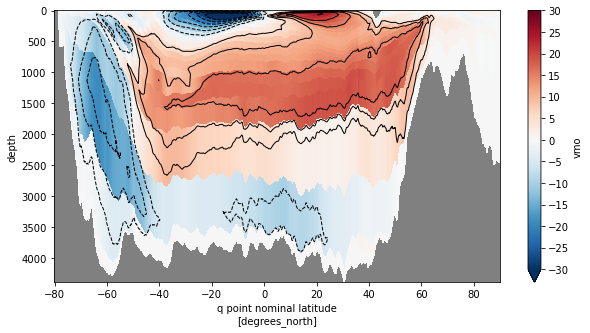

In [77]:
fig, ax = plt.subplots(figsize=(10,5))
psi.plot(ax=ax,x='yq', y='depth',yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                              cbar_kwargs={'ticks': np.arange(-30,35,5)})
psi.plot.contour(ax=ax, x='yq', y='depth', yincrease=False, 
                 levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                 colors='k', linewidths=1)
ax.set_facecolor('gray')
plt.show()

In [78]:
with ProgressBar():
    rho_zmean = rho2.mean('time').mean('xh').load()

[########################################] | 100% Completed | 32.0s


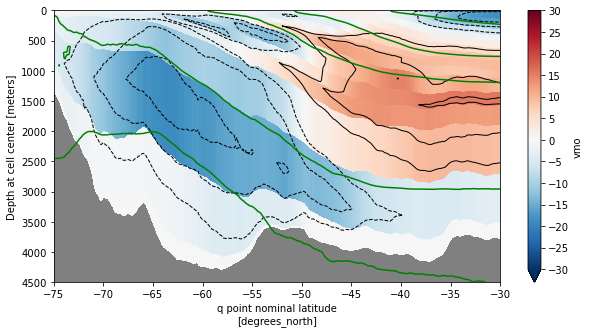

In [79]:
fig, ax = plt.subplots(figsize=(10,5))
psi.plot(ax=ax,x='yq', y='depth',yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                              cbar_kwargs={'ticks': np.arange(-30,35,5)})
psi.plot.contour(ax=ax, x='yq', y='depth', yincrease=False, 
                 levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                 colors='k', linewidths=1)
rho_zmean.plot.contour(ax=ax,x='yq', y='z_l',yincrease=False,colors='g',lw=2,
                       levels=[1035,1036,1036.5,1037,1037.1])
ax.set_xlim((-75,-30))
ax.set_ylim((4500,0))
ax.set_facecolor('gray')
plt.show()

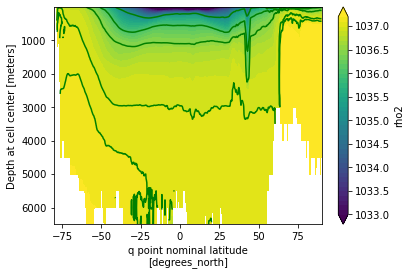

In [80]:
rho_zmean.plot.contourf(x='yq', y='z_l',yincrease=False,levels=np.arange(1033,1037.3,0.1))
rho_zmean.plot.contour(x='yq', y='z_l',yincrease=False,colors='g',lw=2,levels=[1035,1036,1036.5,1037,1037.1])

In [81]:
# zonal mean based on MOM6-AnalysisCookbook/docs/notebooks/spatial_operations.ipynb

In [82]:
# proper zonal mean
def zonal_mean(da, metrics):
    num = (da * metrics['dxCv'] * metrics['wet_v']).sum(dim=['xh'])
    denom = (metrics['dxCv'] * metrics['wet_v']).sum(dim=['xh'])
    return num/denom

In [83]:
with ProgressBar():
    rho2_zm = zonal_mean(rho2.mean('time'),dsgrid_p25).load()

[########################################] | 100% Completed | 32.2s


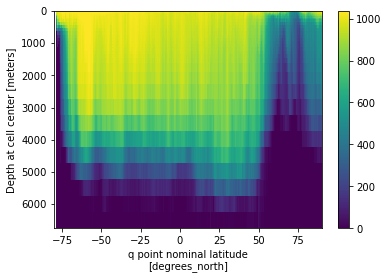

In [84]:
### What went wrong here?
rho2_zm.plot(x='yq', y='z_l',yincrease=False)

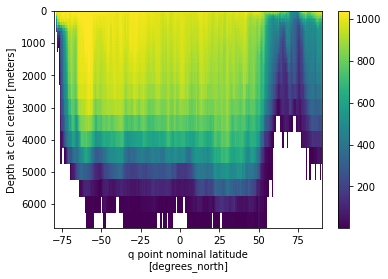

In [85]:
rho2_zm.where(rho2_zm>0).plot(x='yq', y='z_l',yincrease=False)

## Misc options

xoverturning also have more specialized options such as `remove_hml` that is used to remove the signal ov `vhml` and a `rotate` option attempting to rotate to true north. This latest option is still in progress and will be updated. 